In [1]:
import os
import numba
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import entropy
from toolz import frequencies, sliding_window, compose, partial
from aging.dlight.windowing import window_trials_as_mtx
from aging.dlight.stats import bootstrap_lineplot, bootstrap_ci
from aging.behavior.syllables import relabel_by_usage
from aging.plotting import legend, format_plots, figure, save_factory, PlotConfig

In [2]:
numba.set_num_threads(int(os.environ.get("SLURM_JOB_CPUS_PER_NODE", 1)))

In [3]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "dlight", tight_layout=False)

In [4]:
version = 7
file = Path(
    f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/dlight_photometry_df_filter_stats.parquet"
)

In [5]:
def zscore(arr):
    return (arr - arr.mean()) / arr.std()

In [6]:
df = pd.read_parquet(file)

In [7]:
df = relabel_by_usage(df, return_map=False)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8249401 entries, 0 to 8249400
Data columns (total 22 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   pmt00_ref00 (dLight)        float64       
 1   pmt00_ref01 (UV)            float64       
 2   timestamp                   float64       
 3   raw_timestamp               float64       
 4   fs                          float64       
 5   ir_indices                  float64       
 6   subject_name                object        
 7   session_name                object        
 8   start_time                  datetime64[us]
 9   syllables                   int64         
 10  uuid                        object        
 11  dlight_dff                  float64       
 12  uv_dff                      float64       
 13  dlight_reref                float64       
 14  uv_reference_fit            float64       
 15  dlight_reref_zscore         float64       
 16  dlight_reref_zscor

In [9]:
df['subject_name'].unique()

array(['98w-4', '98w-3', '98w-1', '52w-2', '52w-1', '52w-3', '52w-4',
       '12w-2', '12w-4', '12w-3', '98w-5', '12w-5', '52w-5', '98w-2',
       '12w-6', '12w-7'], dtype=object)

In [10]:
df['age'] = df['subject_name'].transform(lambda x: x.split('-')[0])

In [31]:
filt_df = df.query('snr > 4 & session_motion_corr < 0.20')

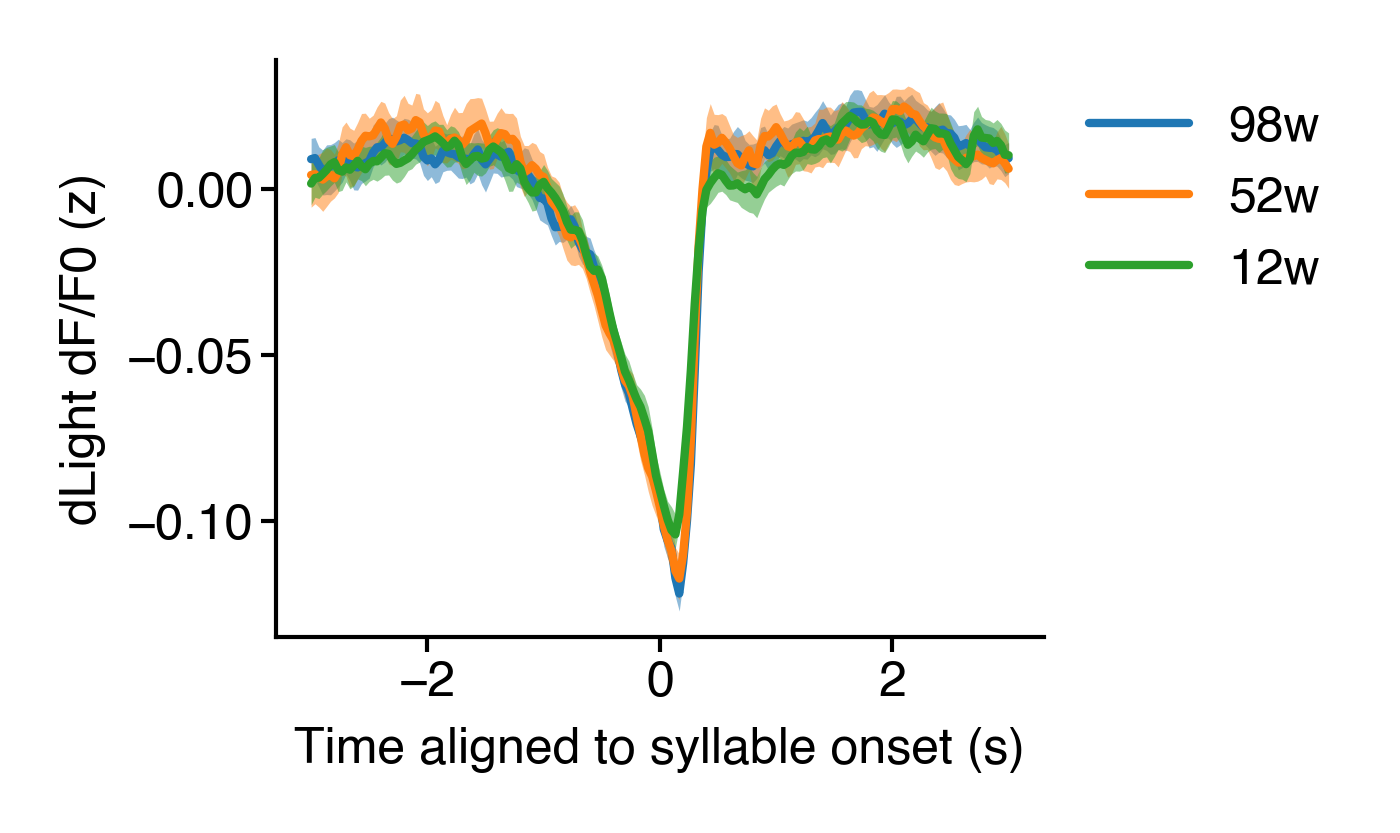

In [12]:
fig = figure(1.65, 1.25)
for age, _df in filt_df.groupby("age", sort=False):
    time, mtx = window_trials_as_mtx(
        _df,
        np.where(_df["onsets"])[0],
        "dlight_reref_zscore",
        truncation_window=(-3, 3),
    )
    mus = bootstrap_ci(mtx.astype('float32'), n_boots=50)
    ax = bootstrap_lineplot(time, mus, label=age)
ax.set(ylabel="dLight dF/F0 (z)", xlabel="Time aligned to syllable onset (s)")
sns.despine()
legend(ax)
# saver(fig, "dlight-aligned-waveforms-across-age");

## Next stage

In [32]:
syllables = filt_df['syllables'].unique()

In [14]:
def get_peak_height(df):
    peaks = {}
    mask = df['onsets']
    for syll in df['syllables'].unique():
        syll_mask = df['syllables'] == syll
        time, mtx = window_trials_as_mtx(df, np.where(mask & syll_mask)[0], "dlight_reref_zscore", truncation_window=(0, 0.3))
        maxes = np.nanmax(mtx, axis=1)
        peaks[syll] = np.nanmean(maxes)
    ser = pd.Series(peaks, name="Peak DA")
    ser.index.name = "syllables"
    return ser

## Correlate syllable usage and dLight for each age

In [33]:
syll_counts = (
    filt_df.query("onsets")
    .groupby(["age", "subject_name", "uuid"])["syllables"]
    .value_counts()
)

In [34]:
syll_counts

age  subject_name  uuid                                  syllables
12w  12w-2         0009ffac-2c8a-4b19-9856-4f0c921c375e  18           284
                                                         98           182
                                                         37           176
                                                         11           169
                                                         86           154
                                                                     ... 
98w  98w-5         bf10f45a-f14f-483c-853c-21d199da4827  61             2
                                                         38             1
                                                         95             1
                                                         1              1
                                                         14             1
Name: count, Length: 5473, dtype: int64

In [35]:
out = filt_df.groupby(['age', 'subject_name', 'uuid']).apply(get_peak_height)

In [47]:
da_usage = pd.DataFrame(syll_counts).join(out)
da_usage = da_usage.query('count > 30')
da_usage['Peak DA'] = da_usage.groupby('uuid')['Peak DA'].transform(zscore)
# da_usage['count'] = da_usage.groupby('uuid')['count'].transform(zscore)

In [48]:
da_usage.groupby('age').corr(method='spearman')

count   Peak DA
age                            
12w count    1.000000 -0.064339
    Peak DA -0.064339  1.000000
52w count    1.000000 -0.057865
    Peak DA -0.057865  1.000000
98w count    1.000000 -0.015646
    Peak DA -0.015646  1.000000

<Axes: xlabel='Peak DA', ylabel='count'>

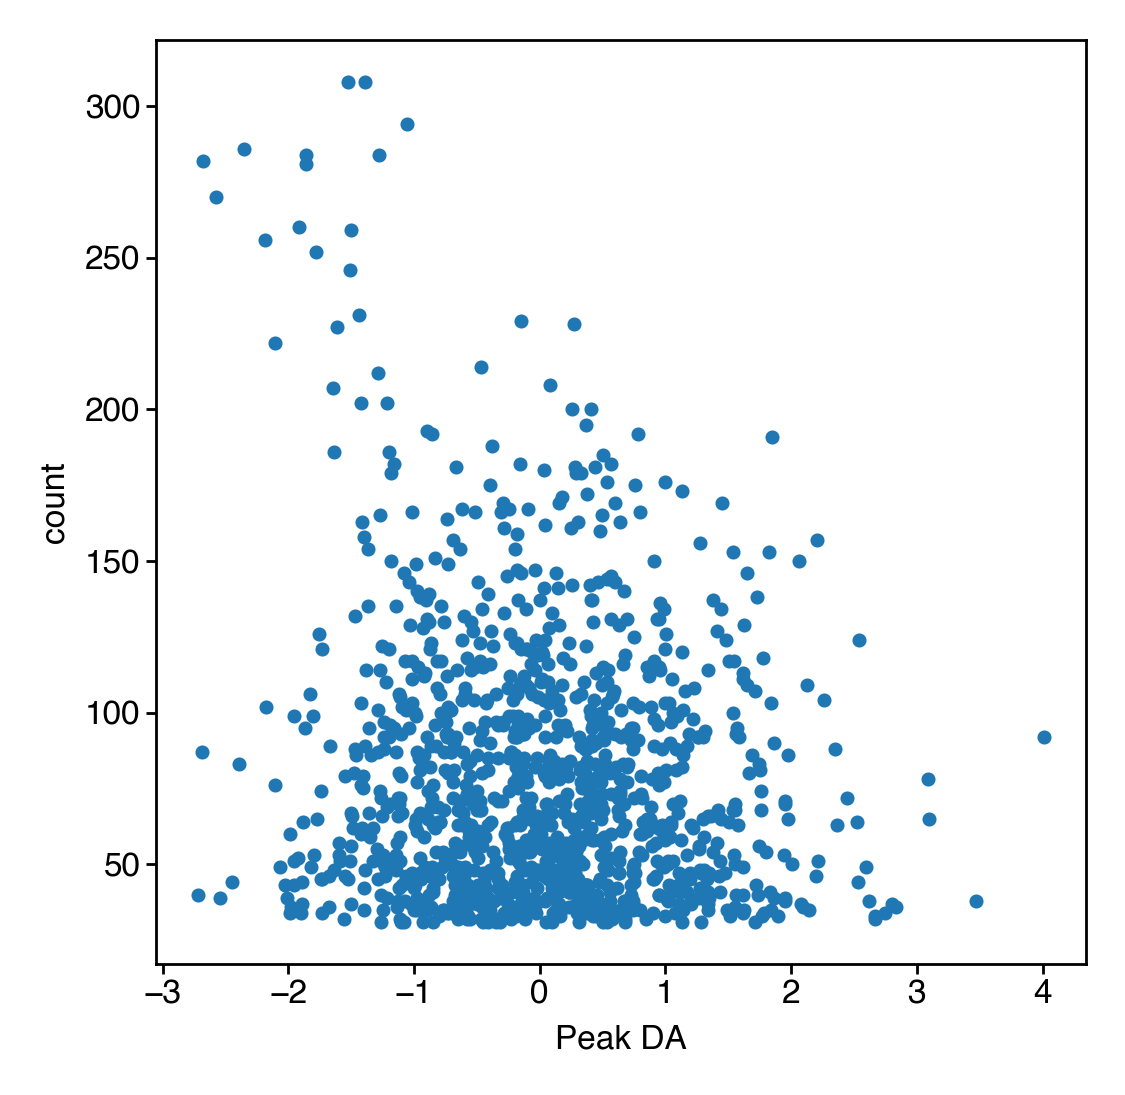

In [49]:
da_usage.loc['12w'].plot(kind='scatter', x='Peak DA', y='count', s=3)

<Axes: xlabel='Peak DA', ylabel='count'>

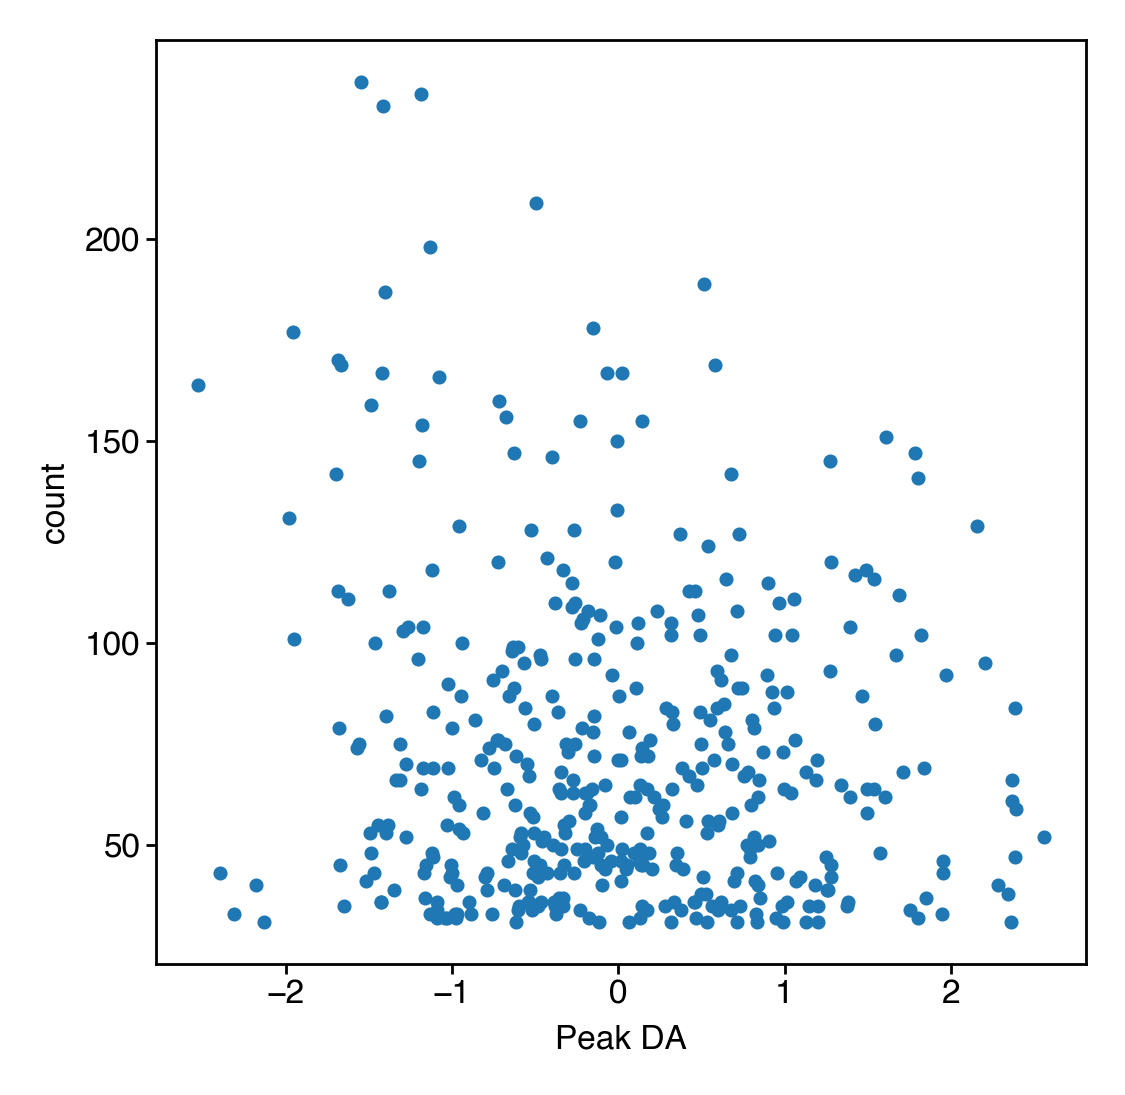

In [50]:
da_usage.loc['52w'].plot(kind='scatter', x='Peak DA', y='count', s=3)

<Axes: xlabel='Peak DA', ylabel='count'>

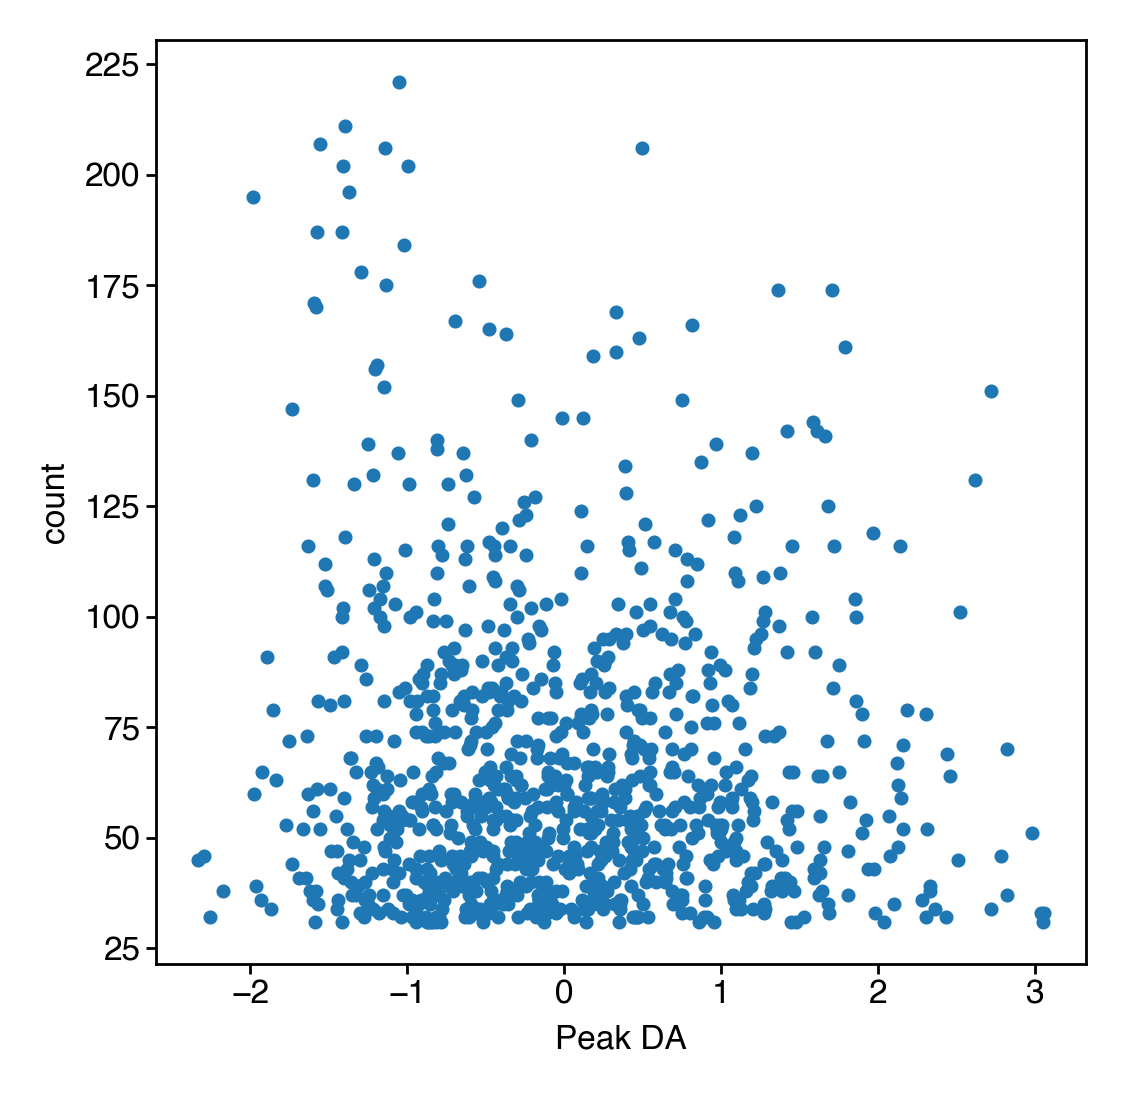

In [51]:
da_usage.loc['98w'].plot(kind='scatter', x='Peak DA', y='count', s=3)

[Text(55.725555555555545, 0.5, 'Syllable counts'),
 Text(0.5, 32.999999999999986, 'Peak DA (z)')]

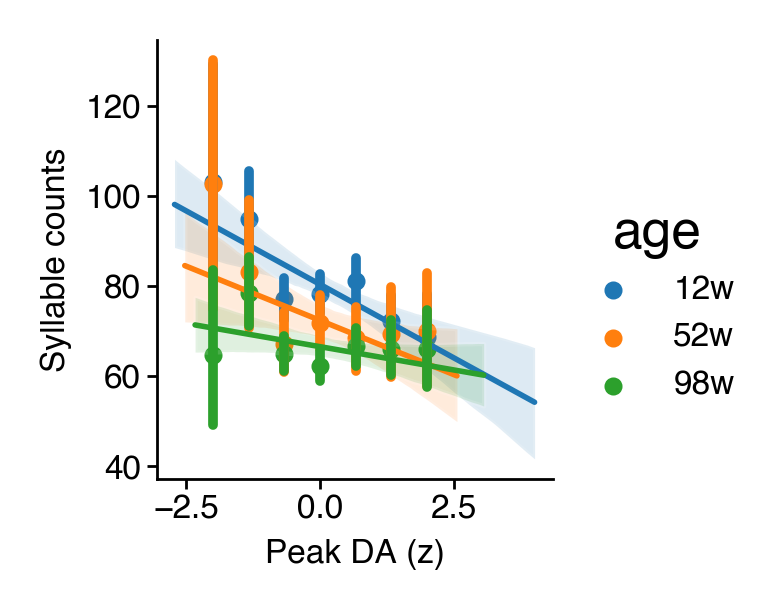

In [52]:
g = sns.lmplot(
    data=da_usage.reset_index(),
    x="Peak DA",
    y="count",
    hue="age",
    x_bins=np.linspace(-2, 2, 7),
    height=1.5,
    aspect=1,
    scatter_kws=dict(s=6),
    line_kws=dict(lw=1),
)
g.ax.set(ylabel="Syllable counts", xlabel="Peak DA (z)")
# saver(g.fig, "dlight-vs-counts-vs-age");

In [24]:
def compute_tm(df, max_syll=100):
    freq_dict = frequencies(sliding_window(2, df['relabeled_syllables'].to_numpy()))
    arr = np.zeros((max_syll, ) * 2)
    for k, v in freq_dict.items():
        arr[k] = v
    return arr

In [25]:
def compute_entropy(tm, count_thresh=30):
    keep = np.where(tm.sum(1) >= count_thresh)[0]
    ent = entropy(tm[keep] + 1, axis=1)
    ser = pd.Series(dict(zip(keep, ent)), name='entropy')
    ser.index.name = 'syllables'
    return ser

In [26]:
fun = compose(
    partial(compute_entropy, count_thresh=20), partial(compute_tm, max_syll=73)
)
ent_out = filt_df.query("onsets").groupby(["age", "subject_name", "uuid"]).apply(fun)

In [27]:
da_ent = pd.DataFrame(ent_out).join(out)
da_ent['Peak DA'] = da_ent.groupby('uuid')['Peak DA'].transform(zscore)
# da_ent['entropy'] = da_ent.groupby('uuid')['entropy'].transform(zscore)

In [28]:
da_ent.groupby('age').corr(method='spearman')

entropy   Peak DA
age                            
12w entropy  1.000000 -0.000839
    Peak DA -0.000839  1.000000
52w entropy  1.000000  0.082591
    Peak DA  0.082591  1.000000
98w entropy  1.000000  0.063595
    Peak DA  0.063595  1.000000

[Text(54.330347222222215, 0.5, 'Entropy (nats)'),
 Text(0.5, 32.999999999999986, 'Peak DA (z)')]

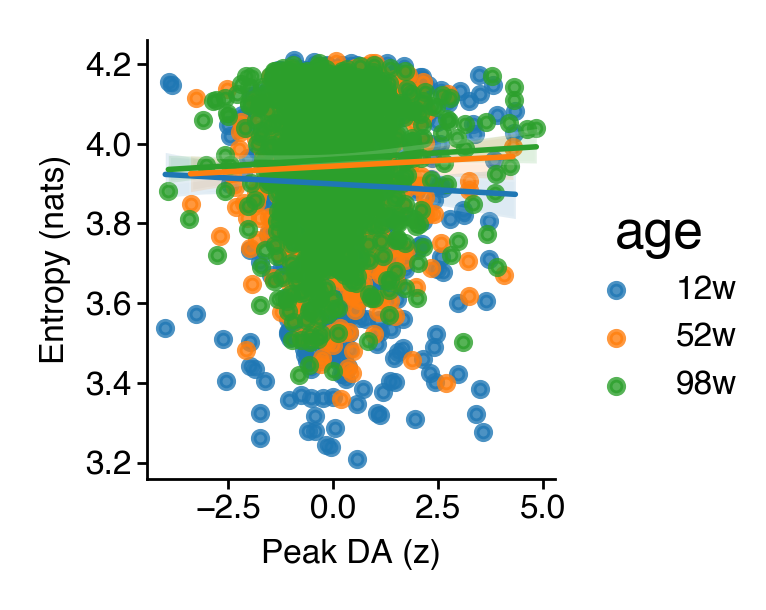

In [29]:
g = sns.lmplot(
    data=da_ent.reset_index(),
    x="Peak DA",
    y="entropy",
    hue="age",
    height=1.5,
    aspect=1,
    scatter_kws=dict(s=6),
    line_kws=dict(lw=1),
)
g.ax.set(ylabel="Entropy (nats)", xlabel="Peak DA (z)")

[Text(54.330347222222215, 0.5, 'Entropy (nats)'),
 Text(0.5, 32.999999999999986, 'Peak DA (z)')]

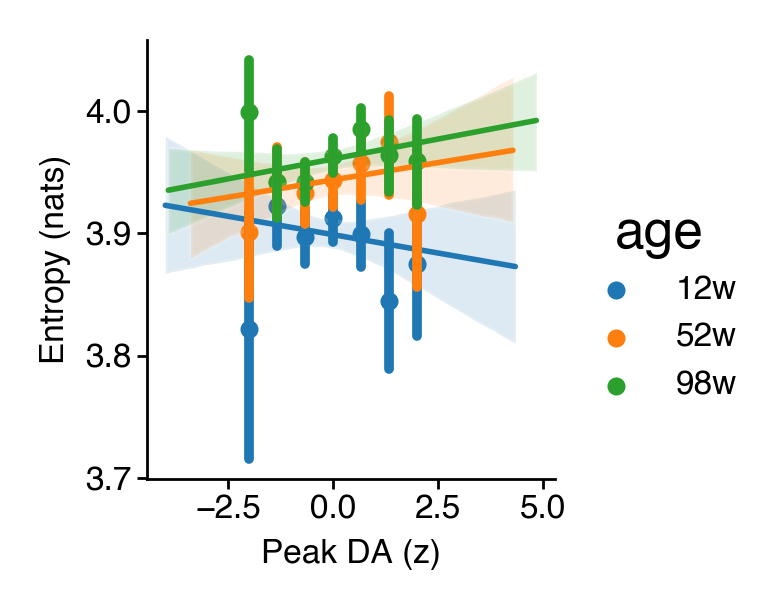

In [30]:
g = sns.lmplot(
    data=da_ent.reset_index(),
    x="Peak DA",
    y="entropy",
    hue="age",
    x_bins=np.linspace(-2, 2, 7),
    height=1.5,
    aspect=1,
    scatter_kws=dict(s=6),
    line_kws=dict(lw=1),
)
g.ax.set(ylabel="Entropy (nats)", xlabel="Peak DA (z)")
# saver(g.fig, "dlight-vs-entropy-vs-age");